# Use `Lale` `AIF360` scorers to calculate and mitigate bias for credit risk AutoAI model

This notebook contains the steps and code to demonstrate support of AutoAI experiments in watsonx.ai Runtime service. It introduces commands for bias detecting and mitigation performed with `lale.lib.aif360` module.

Some familiarity with Python is helpful. This notebook uses Python 3.11.

## Contents

This notebook contains the following parts:

1. [Setup](#setup)
2. [Optimizer definition](#definition)
3. [Experiment Run](#run)
4. [Pipeline bias detection and mitigation](#bias)
5. [Deployment and score](#scoring)
6. [Clean up](#cleanup)
7. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

If you are not familiar with <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Runtime Service</a> and AutoAI experiments please read more about it in the sample notebook: <a href="https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/experiments/autoai/Use%20AutoAI%20and%20Lale%20to%20predict%20credit%20risk.ipynb" target="_blank" rel="noopener no referrer">"Use AutoAI and Lale to predict credit risk."</a>

### Install and import the `ibm-watsonx-ai`, `lale` ,`aif360` and dependencies.
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget
!pip install "scikit-learn==1.3.0" | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1
!pip install -U autoai-libs | tail -n 1
!pip install -U 'lale[fairness]>=0.8.2,<0.9' | tail -n 1

### Connection to watsonx.ai Runtime

Authenticate the watsonx.ai Runtime service on IBM Cloud. You need to provide Cloud `API key` and `location`.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the watsonx.ai Runtime docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Runtime Service</a> instance details.


You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve the instance `location`.

```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance INSTANCE_NAME
```


**NOTE:** You can also get a service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, and then copy the created key and paste it in the following cell.  


**Action**: Enter your `api_key` and `location` in the following cell.

In [2]:
api_key = 'PASTE YOUR PLATFORM API KEY HERE'
location = 'PASTE YOUR INSTANCE LOCATION HERE'

In [4]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    api_key=api_key,
    url='https://' + location + '.ml.cloud.ibm.com'
)

In [5]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Working with spaces

You need to create a space that will be used for your work. If you do not have a space, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click **New Deployment Space**
- Create an empty space
- Select Cloud Object Storage
- Select watsonx.ai Runtime instance and press **Create**
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: assign space ID below


In [7]:
space_id = 'PASTE YOUR SPACE ID HERE'

In [ ]:
client.spaces.list(limit=10)

In [8]:
client.set.default_space(space_id)

'SUCCESS'

### Connections to COS

In next cell we read the COS credentials from the space.

In [9]:
cos_credentials = client.spaces.get_details(space_id=space_id)['entity']['storage']['properties']

<a id="definition"></a>
## 2. Optimizer definition

### Training data connection

Define connection information to COS bucket and training data CSV file. This example uses the [German Credit Risk dataset](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/data/credit_risk/credit_risk_training_light.csv).

The code in next cell uploads training data to the bucket.

In [10]:
filename = 'german_credit_data_biased_training.csv'
datasource_name = 'bluemixcloudobjectstorage'
bucketname = cos_credentials['bucket_name']

Download training data from git repository and split for training and test set.

In [11]:
import os, wget
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

url = 'https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/data/credit_risk/german_credit_data_biased_training.csv'
if not os.path.isfile(filename): wget.download(url)

credit_risk_df = pd.read_csv(filename)

X = credit_risk_df.drop(['Risk'], axis=1)
y = credit_risk_df['Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

credit_risk_df.head()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk


#### Create connection

In [12]:
conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: f"Connection to Database - {datasource_name} ",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: client.connections.get_datasource_type_id_by_name(datasource_name),
    client.connections.ConfigurationMetaNames.DESCRIPTION: "Connection to external Database",
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': bucketname,
        'access_key': cos_credentials['credentials']['editor']['access_key_id'],
        'secret_key': cos_credentials['credentials']['editor']['secret_access_key'],
        'iam_url': 'https://iam.cloud.ibm.com/identity/token',
        'url': cos_credentials['endpoint_url']
    }
}

conn_details = client.connections.create(meta_props=conn_meta_props)

Creating connections...
SUCCESS


**Note**: The above connection can be initialized alternatively with `api_key` and `resource_instance_id`.  
The above cell can be replaced with:


```
conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: f"Connection to Database - {db_name} ",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: client.connections.get_datasource_type_id_by_name(db_name),
    client.connections.ConfigurationMetaNames.DESCRIPTION: "Connection to external Database",
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': bucket_name,
        'api_key': cos_credentials['apikey'],
        'resource_instance_id': cos_credentials['resource_instance_id'],
        'iam_url': 'https://iam.cloud.ibm.com/identity/token',
        'url': 'https://s3.us.cloud-object-storage.appdomain.cloud'
    }
}

conn_details = client.connections.create(meta_props=conn_meta_props)

```

In [13]:
connection_id = client.connections.get_id(conn_details)

Define connection information to training data and upload train dataset to COS bucket.


In [14]:
from ibm_watsonx_ai.helpers import DataConnection, S3Location


credit_risk_conn = DataConnection(
    connection_asset_id=connection_id,
    location=S3Location(bucket=bucketname,
                        path=filename))

credit_risk_conn.set_client(client)
training_data_reference=[credit_risk_conn]


credit_risk_conn.write(data=X_train.join(y_train), remote_name=filename)

### Optimizer configuration

Provide the input information for AutoAI optimizer:
- `name` - experiment name
- `prediction_type` - type of the problem
- `prediction_column` - target column name
- `scoring` - optimization metric
- `daub_include_only_estimators` - estimators which will be included during AutoAI training. More available estimators can be found in `experiment.ClassificationAlgorithms` enum

In [15]:
from ibm_watsonx_ai.experiment import AutoAI

experiment = AutoAI(credentials, space_id=space_id)

pipeline_optimizer = experiment.optimizer(
    name='Credit Risk Bias detection in AutoAI',
    prediction_type=AutoAI.PredictionType.BINARY,
    prediction_column='Risk',
    scoring=AutoAI.Metrics.ROC_AUC_SCORE,
    include_only_estimators=[experiment.ClassificationAlgorithms.XGB]    
)

<a id="run"></a>
## 3. Experiment run

Call the `fit()` method to trigger the AutoAI experiment. You can either use interactive mode (synchronous job) or background mode (asychronous job) by specifying `background_model=True`.

In [16]:
run_details = pipeline_optimizer.fit(
            training_data_reference=training_data_reference,
            background_mode=False)

Training job 2ce3bcf7-61e7-4239-b176-703a54153d47 completed: 100%|████████| [02:22<00:00,  1.42s/it]


In [17]:
pipeline_optimizer.get_run_status()

'completed'

In [18]:
summary = pipeline_optimizer.summary()
summary

,Enhancements,Estimator,training_roc_auc_(optimized),holdout_average_precision,holdout_log_loss,training_accuracy,holdout_roc_auc,training_balanced_accuracy,training_f1,holdout_precision,training_average_precision,training_log_loss,holdout_recall,training_precision,holdout_accuracy,holdout_balanced_accuracy,training_recall,holdout_f1
Pipeline Name,,,,,,,,,,,,,,,,,,
Pipeline_1,,XGBClassifier,0.849548,0.463730,0.325270,0.791822,0.844928,0.743832,0.850269,0.856716,0.913282,0.439842,0.959866,0.814708,0.866370,0.819933,0.889306,0.905363
Pipeline_3,"HPO, FE",XGBClassifier,0.851765,0.480070,0.419824,0.796035,0.844738,0.742230,0.855107,0.808260,0.915108,0.435144,0.916388,0.810329,0.799555,0.741527,0.905333,0.858934
Pipeline_4,"HPO, FE, HPO",XGBClassifier,0.852351,0.479104,0.415105,0.796283,0.844470,0.740031,0.855952,0.815476,0.915429,0.433372,0.916388,0.807718,0.806236,0.751527,0.910550,0.862992
Pipeline_2,HPO,XGBClassifier,0.856582,0.475123,0.387556,0.806196,0.843501,0.755012,0.861962,0.830409,0.917558,0.428008,0.949833,0.818676,0.837416,0.781583,0.910180,0.886115


### Get selected pipeline model

Download pipeline model object from the AutoAI training job.

In [19]:
best_pipeline = pipeline_optimizer.get_pipeline()

<a id="bias"></a>
## 4. Bias detection and mitigation

The `fairness_info` dictionary contains some fairness-related metadata. The favorable and unfavorable label are values of the target class column that indicate whether the loan was granted or denied. A protected attribute is a feature that partitions the population into groups whose outcome should have parity. The credit-risk dataset has two protected attribute columns, sex and age. Each prottected attributes has monitored and reference group.


In [20]:
fairness_info = {'favorable_labels': ['No Risk'],
                 'protected_attributes': [
                     {'feature': 'Sex','reference_group': ['male'], 'monitored_group': ['female']},
                     {'feature': 'Age', 'reference_group': [[26, 40]],  'monitored_group': [[18.0, 25.0], [41.0, 75.0]]}]}
fairness_info

{'favorable_labels': ['No Risk'],
 'protected_attributes': [{'feature': 'Sex',
   'reference_group': ['male'],
   'monitored_group': ['female']},
  {'feature': 'Age',
   'reference_group': [[26, 40]],
   'monitored_group': [[18.0, 25.0], [41.0, 75.0]]}]}

### Calculate fairness metrics

We will calculate some model metrics. Accuracy describes how accurate is the model according to dataset. 
Disparate impact is defined by comparing outcomes between a privileged group and an unprivileged group, 
so it needs to check the protected attribute to determine group membership for the sample record at hand.
The third calculated metric takes the disparate impact into account along with accuracy. The best value of the score is 1.0.

In [21]:
import sklearn.metrics
from lale.lib.aif360 import disparate_impact, accuracy_and_disparate_impact

accuracy_scorer = sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score)
print(f'accuracy {accuracy_scorer(best_pipeline, X_test, y_test):.1%}')
disparate_impact_scorer = disparate_impact(**fairness_info)
print(f'disparate impact {disparate_impact_scorer(best_pipeline, X_test, y_test):.2f}')
combined_scorer = accuracy_and_disparate_impact(**fairness_info)
print(f'accuracy and disparate impact metric {combined_scorer(best_pipeline, X_test, y_test):.2f}')

accuracy 80.0%
disparate impact 0.79
accuracy and disparate impact metric 0.80


### Mitigation

`Hyperopt` minimizes (best_score - score_returned_by_the_scorer), where best_score is an argument to Hyperopt and score_returned_by_the_scorer is the value returned by the scorer for each evaluation point. We will use the `Hyperopt` to tune hyperparametres of the AutoAI pipeline to get new and more fair model. 


In [22]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.neighbors import KNeighborsClassifier as KNN
from lale.lib.lale import Hyperopt
from lale.lib.aif360 import FairStratifiedKFold
from lale import wrap_imported_operators

wrap_imported_operators()

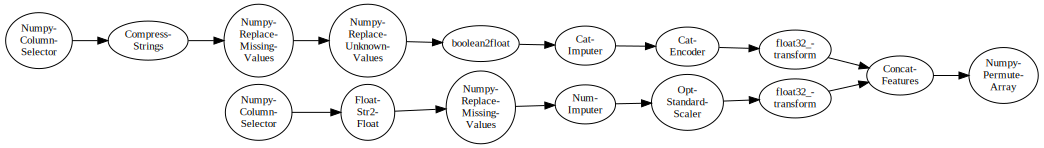

In [23]:
prefix = best_pipeline.remove_last().freeze_trainable()
prefix.visualize()

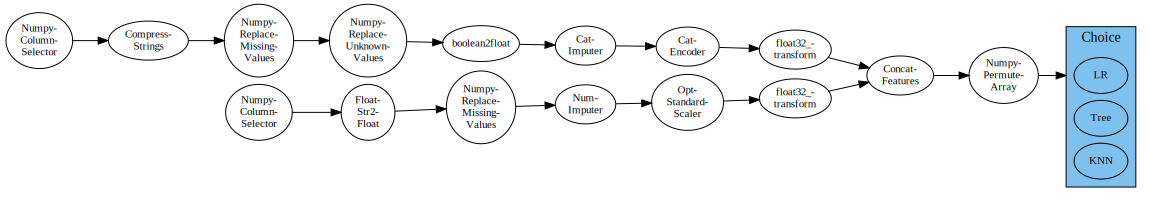

In [24]:
new_pipeline = prefix >> (LR | Tree | KNN)
new_pipeline.visualize()

In [25]:
fair_cv = FairStratifiedKFold(**fairness_info, n_splits=3)

pipeline_fairer = new_pipeline.auto_configure(
    X_train, y_train, optimizer=Hyperopt, cv=fair_cv,
    max_evals=10, scoring=combined_scorer, best_score=1.0)

100%|██████████| 10/10 [00:23<00:00,  2.36s/trial, best loss: 0.16252017200929048]


As with any trained model, we can evaluate and visualize the result.

accuracy 73.4%
disparate impact 0.95
accuracy and disparate impact metric 0.84


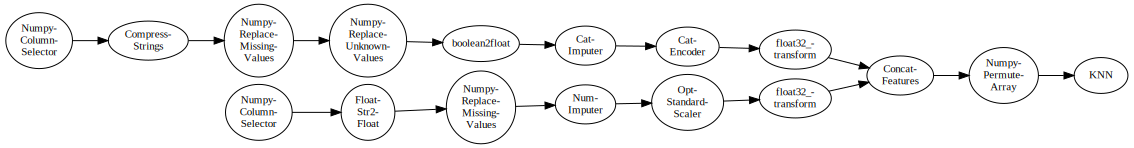

In [26]:
print(f'accuracy {accuracy_scorer(pipeline_fairer, X_test, y_test):.1%}')
print(f'disparate impact {disparate_impact_scorer(pipeline_fairer, X_test, y_test):.2f}')
print(f'accuracy and disparate impact metric {combined_scorer(pipeline_fairer, X_test, y_test):.2f}')
pipeline_fairer.visualize()

As the result demonstrates, the best model found by AI Automation
has lower accuracy and much better disparate impact as the one we saw
before. Also, it has tuned the repair level and
has picked and tuned a classifier. These results may vary by dataset and search space.

You can get source code of the created pipeline. You just need to change the below cell type `Raw NBCovert` to `code`.

<a id="scoring"></a>
## 5. Deploy and Score
In this section you will learn how to deploy and score Lale pipeline model using watsonx.ai Runtime instance.

### Store the model

In [27]:
model_props = {
    client.repository.ModelMetaNames.NAME: "Fairer AutoAI model",
}
feature_vector = list(X.columns)

Get training's id from run details.

In [31]:
training_id = run_details["metadata"]["id"]

In [32]:
published_model = client.repository.store_model(
    model=best_pipeline.export_to_sklearn_pipeline(), 
    meta_props=model_props,
    training_id=training_id
)

In [33]:
published_model_id = client.repository.get_model_id(published_model)

### Deployment creation

In [34]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of fairer model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(published_model_id, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: 'e24634ea-0e3f-4b61-b6cf-4f9254f1ce88' started

#######################################################################################


initializing
Note: online_url and serving_urls are deprecated and will be removed in a future release. Use inference instead.
..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='d319ef76-0431-4554-b7a5-bdb3291e9bf7'
------------------------------------------------------------------------------------------------




In [35]:
deployment_id = client.deployments.get_id(created_deployment)

#### Deployment scoring 

You need to pass scoring values as input data if the deployed model. Use `client.deployments.score()` method to get predictions from deployed model. 

In [36]:
values = X_test.values

scoring_payload = {
    "input_data": [{
        'values': values[:5]
    }]
}

In [37]:
predictions = client.deployments.score(deployment_id, scoring_payload)
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [['Risk', [0.019100427627563477, 0.9808995723724365]],
    ['No Risk', [0.9091408252716064, 0.09085915237665176]],
    ['No Risk', [0.696623682975769, 0.30337631702423096]],
    ['Risk', [0.40442538261413574, 0.5955746173858643]],
    ['No Risk', [0.9562923908233643, 0.04370759055018425]]]}]}

<a id="cleanup"></a>
## 5. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 6. Summary and next steps

 You successfully completed this notebook!.

Check out used packeges domuntations:
- `ibm-watsonx-ai` [Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai)
- `lale`: https://github.com/IBM/lale
- `aif360`: https://aif360.mybluemix.net/

### Authors 

**Dorota Lączek**, Software Engineer at watsonx.ai

**Mateusz Szewczyk**, Software Engineer at watsonx.ai

Copyright © 2020-2025 IBM. This notebook and its source code are released under the terms of the MIT License.